In [1]:
#Pkg.add("LsqFit")
#Pkg.add("PyPlot")
#Pkg.add("LaTeXStrings")

In [2]:
using LsqFit, PyPlot, LaTeXStrings

## Puntos fijos y criterio del Jacobiano

Buscamos $(P,Q)$ tal que 

$$
\begin{aligned}
P &= P \left( 1+r \left( 1-P \right)\right)-s P Q\\
Q &= (1-u)Q+v P Q
\end{aligned}
$$

Los puntos fijos son:


\begin{aligned}
E_0 &= [0.0 ,0.0]\\
E_1 &= [1.0 ,0.0]\\
E_2 &= \left[\frac{u}{v} ,\frac{r}{s}\left(1-\frac{u}{ v} \right) \right]
\end{aligned}

Como sólo nos interesan los puntos positivos, necesitamos que $\frac{u}{v}<1$ i.e. $u<v$

El criterio del Jacobiano dice: Siendo la matriz Jacobiana $J$, si los eigenvalores de $J$, complejos o reales cumplen con $|\lambda_i>1|$, el punto es inestable. Para valores con $|\lambda_i=1|$, el criterio no determina.

El jacobiano del mapeo para $E_2$:

$$
J(E_2)=
\begin{pmatrix}
1-\frac{ru}{v} & -\frac{su}{v} \\ 
 \frac{r(-u+v)}{s}& 1
\end{pmatrix}
$$

La ecuación característica del Jacobiano:

$$\lambda^2+r_1\lambda+r_2=0$$

con $r_1=-trJ=-2+\frac{ru}{v}$, $r_2=detJ=1+\frac{ru(-1-u+v)}{v}$:

Entonces:

$$
\lambda_{+,-}=-\frac{\alpha_1}{2}\pm\sqrt{\Delta}=1-\frac{ru}{2v}\pm\sqrt{\Delta}
$$

donde $\Delta=\left(\frac{r_1}{2}\right)^2-r_2=\frac{ru\left(ru+4uv-4v^2\right)}{4v^2}$


###### Valores complejos de los eigenvalores:
Si $\Delta< 0$, entonces $r<-\frac{4(uv-v^2)}{u}$.

Para $\left |\lambda_{+,-}  \right | \leq 1$
1. $v \leq 1$
2. $v \leq u+1$

###### Valores reales de los eigenvalores:
Si $\Delta \geq 0$, entonces $r\geq-\frac{4(uv-v^2)}{u}$:

Siempre se cumple para $\lambda_{+,-}\leq1$

Para $\lambda_{+}\geq-1$
3. $v \leq 1$
4. $v \leq u+1$
6. $r\geq\frac{4v}{u(2+u-v)}$ con $v<2$ ó $v<2+u$ 

$\lambda_{-}\geq-1$
4. $v=u=1$ y $r\leq2$
5. $r\leq\frac{4}{u+u^2}$ con $u\leq\frac{4}{4+r}$ ó $u<1$.
6. $u\geq\frac{4}{4+r}$ con $u>1$.
7. $r=\frac{4v^2}{u}-4v$ con $v>1$ y $v=1+u$
8. $r\leq\frac{4v}{u(2+u-v)}$ con $v<u+1$.
9. $r\leq\frac{4v}{u(2+u-v)}$ con $v<1$, $v\geq u+1$ y $v\leq 2+u$

De aquí se deduce una conclusión importante, parece ser que la estabilidad del punto fijo no depende del parámetro $s$.

Definimos algunas funciones para iniciar el análisis del mapeo.

In [3]:
"""
    CP_Simple(Xt,constantes)

Dado un vector con los valores de la población de presas y depredadores 
Xt=[P,Q], realiza el siguiente paso con el modelo simple.

"""
function CP_Simple(Xt::Vector{Float64},constantes::Vector{Float64})
    
    @assert length(Xt)==2 && length(constantes) == 5
    
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    K = constantes[5]
    
    #Asignación del paso 0
    P0 = Xt[1]
    Q0 = Xt[2]
    #Evaluación del modelo
    P1 = P0*(1+r*(1-P0/K))-s*P0*Q0
    Q1 = (1-u)*Q0+v*P0*Q0
    
    #Resultados
    [P1,Q1]   
end

CP_Simple

In [4]:
"""
    mapeo2D_lista(F,X_0,constantes,t)
Dada una función `F(X_0,constantes)` que define un mapeo de 2 dimensiones
un punto inicial `X_0` y las `constantes` en forma de vector, regresa dos
vectores con los `t` iterados del mapeo para cada dimensión.

"""

function mapeo2D_lista(F::Function , X_0::Vector{Float64},constantes,t::Int64)
    @assert length(X_0)==2 && t > 0
    
    X0 = X_0
    #Definición de los vectores para almacenar resultados.
    Ps = [X0[1]]
    Qs = [X0[2]]
    
    for i in 1:t-1
        X0 = F(X0,constantes)
        push!(Ps,X0[1])
        push!(Qs,X0[2])
    end
    Ps,Qs
end

# Este método permite quedarse sólo con los iterados finales.
function mapeo2D_lista(F::Function , X_0::Vector{Float64},constantes,tin::Int64,tout::Int64)
    
    @assert length(X_0)==2 &&  tin > 0 && tout > 0
    
    X0 = X_0
    
    for i in 1:tin
        X0 = F(X0,constantes)
    end
    
    mapeo2D_lista(F , X0, constantes,tout)

end

# Otro metodo, que emplea una función para determinar el punto inicial en lugar de propocionar el punto directamente.
function mapeo2D_lista(F::Function , p::Function,constantes,tin::Int64,tout::Int64)
    
    X0 = p(constantes)
    
        mapeo2D_lista(F, X0,constantes,tin,tout)
end

mapeo2D_lista (generic function with 3 methods)

In [5]:
"""
    diagbifurc2D(F::Function, X0, rrange::Range{Float64}, tin::Int64,tout::Int64)
Función análoga a la vista, que dado un mapeo definido por `F(X0,r)`, una condición inicial `X0`
o una función que define la condición inicial `X0(r)`, en un rango de la constante `r`, almacena
los `tout`iterados después de los primeros `tin` iterados.
"""

function diagbifurc2D(F::Function, X0, rrange::Range{Float64}, tin::Int64,tout::Int64)
    
    #Definición de variables
    X = Vector{Float64}(tout)
    Y = Vector{Float64}(tout)
    
    xx = Array{Float64,2}(tout, length(rrange))
    yy = Array{Float64,2}(tout, length(rrange))
    
    for ic in eachindex(rrange)
        r = rrange[ic]
        X,Y = mapeo2D_lista(F, X0,r,tin,tout)
        
        xx[:,ic] = X
        yy[:,ic] = Y
    end
    
    return xx,yy
    
end    

diagbifurc2D

In [6]:
"""
    pE2(constantes)
Es una función muy específica, genera el punto fijo del mapeo.
"""
function pE2(constantes)
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    [u/v,r*(1-u/v)/s]
end

pE2

In [7]:
"""
   Δ(constantes)
Es una función muy específica, el discriminante del jacobiano en `E_2`.
"""
function Δ(constantes)
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    r*u*(r*u+4u*v-4v^2)/(4v^2)
end

Δ

In [8]:
"""
    λ(constantes,signo)
Es una función muy específica, los eigen valores del jacobiano en `E_2`.
"""
function λ(constantes,signo)
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    
    1-r*u/(2*v)+signo*sqrt(Δ(constantes))
end

λ

In [9]:
"""
    es_estable(constantes)
Es una función que dice sí dadas las constantes existe un equilibrio estable.
"""
function es_estable(constantes)
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    if Δ(constantes)>=0
        if abs(λ(constantes,1))<1 && abs(λ(constantes,-1))<1
            return 1
        elseif abs(λ(constantes,1))==1 && abs(λ(constantes,-1))==1
            return 0
        else            
            return -1
        end
    else
        if (-2+r*u/v)^2-Δ(constantes)<1
            return 1
        elseif (-2+r*u/v)^2-Δ(constantes)==1
            0
        else
            return -1
        end
    end
end


es_estable

In [10]:
#Debido a una multitud de gráficos similares, esta función ayuda a graficar con la función diagbifurc.
function plot1(F::Function, X_0, range::Range, tin::Int64, tout::Int64, titulo)
    
    Ps,Qs=diagbifurc2D(F,X_0, range, tin,tout)
    Rs = ones(size(Ps)[1])*range'
    
    #Cambio de forma de las matrices.
    Ps = reshape(Ps, size(Ps)[1]*size(Ps)[2]);
    Qs = reshape(Qs, size(Qs)[1]*size(Qs)[2]);
    Rs = reshape(Rs, size(Rs)[1]*size(Rs)[2]);
    
    #Plots
    PyPlot.plot(Rs,Ps,"b,",label=(L"P"))
    PyPlot.plot(Rs,Qs,"r,",label=(L"Q"))
    xlabel(L"r")
    ylabel(L"P_{\infty},Q_{\infty}")
    title(titulo)
    legend()
    #Resultados, en caso de usarse
    Rs,Ps,Qs
end

plot1 (generic function with 1 method)

Ahora se prueban estas regiones. Como el criterio de estabilidad del Jacobiano es muy efectivo, mostraremos sólo algunos casos que ilustran la riqueza de dinámicas que puede presentar este modelo.


Primero, si tenemos $Q=0.0$, es decir sólo a las presas creciendo, entonces el mapeo queda así:

$$P_{t+1} = P_t \left( 1+r \left( 1-P_t \right)\right)$$

$$P_{t+1} =  r+P_t-rP_t^2 $$

Se debería esperar un comportamiento muy similar al del mapeo cuadrático, y en efecto su diagrama de bifuraciones es el mismo. 


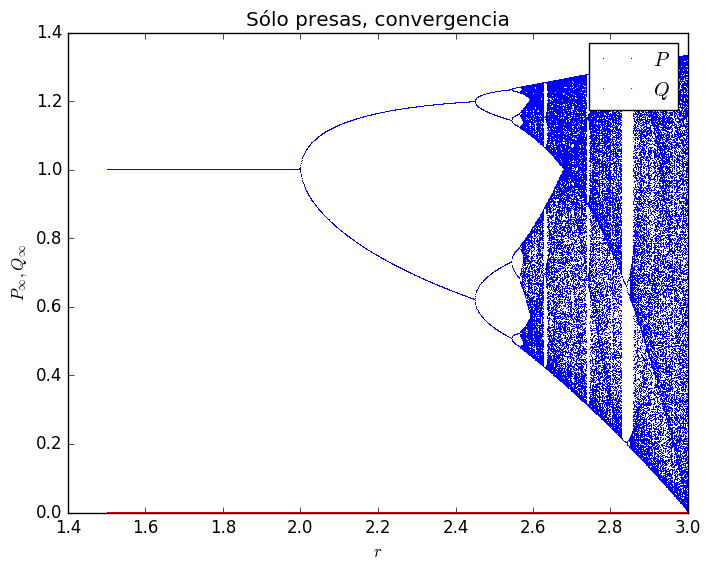

In [12]:
rrange1 = 1.5:2.0^-10:3.0
s,u,v,K = 3.0,1.25,1.95,1.0
X0 = [0.641,0.000]

F1(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);

plot1(F1, X0, rrange1,1000,200, "Sólo presas, convergencia");

La dinámica de las presas, al estar interrelacionada con la de los depredadores, hace que aparezcan bifrucaciones de doblamiento de periódo también en el caso de los depredadores.

### Caso complejo, $\Delta< 0 \Leftrightarrow r<-\frac{4(uv-v^2)}{u}$
1. $v \leq 1$

In [13]:
s,u,v,K = 3.0,0.25,1.0,1.0

#Valor r de referencia.
-4*(u*v-v^2)/u

12.0

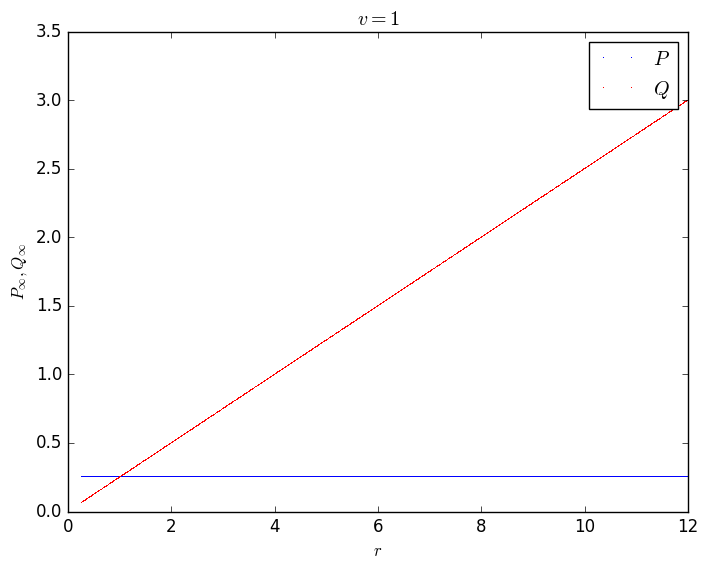

In [14]:
rrange1 = 0.0:2.0^-7:12.0
F1(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);

#La función p sirve para definir valores iniciales cercanobs al punto de equilibrio
pE2_1(r)=pE2([r,s,u,v])+[0.01,-0.061]
plot1(F1, pE2_1, rrange1, 1000,200, L"v=1");

En el gráfico se verifica la estabilidad de la función, después de muchos iterados, los valores de $P$ y $Q$, convergen al punto de equilibrio $E_2$, el cual sólo es dependiente linealmente de $r$ en la componente de $Q$. Es el comportamiento esperado para la función

2. $v \leq 1+u$

In [15]:
s,u,K = 3.0,0.25,1.0
v=1+u
#Valor r de referencia.
-4*(u*v-v^2)/u

20.0

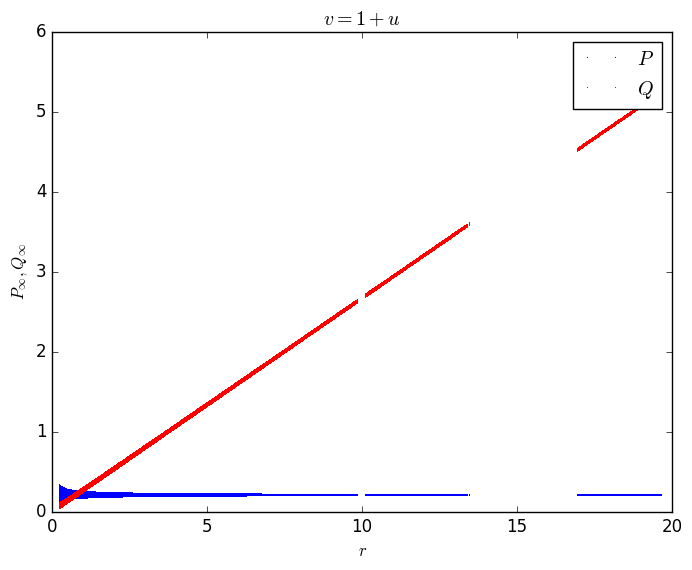

In [16]:
rrange2 = 0.0:2.0^-7:19.6416
F2(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);

#La función p sirve para definir valores iniciales cercanobs al punto de equilibrio
pE2_2(r)=pE2([r,s,u,v])+[0.01,-0.061]
plot1(F2, pE2_2, rrange2, 1000,200,L"v=1+u");

Aquí se observa una zona con bifurcación de Hopf, por eso la región de convergencia tiene forma de trompeta: el tamaño de las órbitas cerradas a las que converge el mapeo se va reduciendo, dependientemente de $r$.

### Caso real, $\Delta \geq 0 \Leftrightarrow r\geq-\frac{4(uv-v^2)}{u}$ y $\lambda_{+}\geq-1$

Se puede ver que los primeros dos casos corresponden a los de la parte compleja.
1. $v \leq 1$

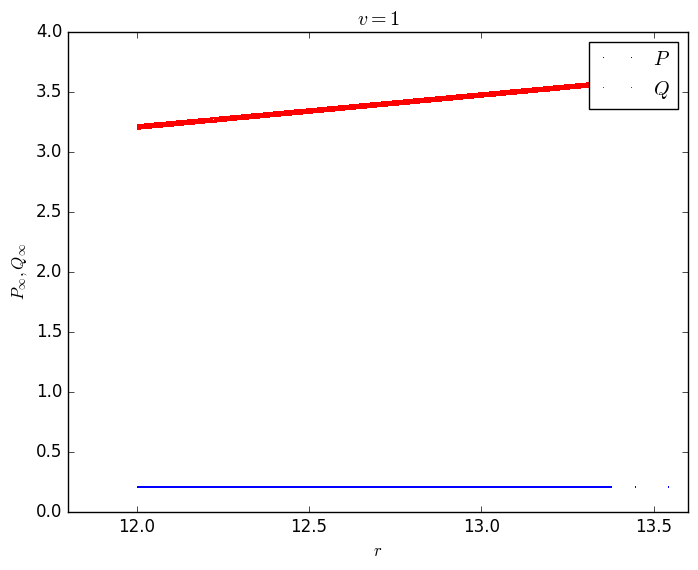

In [17]:
rrange1 = 12.0:2.0^-9:14.0
plot1(F1, pE2_1, rrange1, 1000,200, L"v=1");

2. $v \leq 1+u$

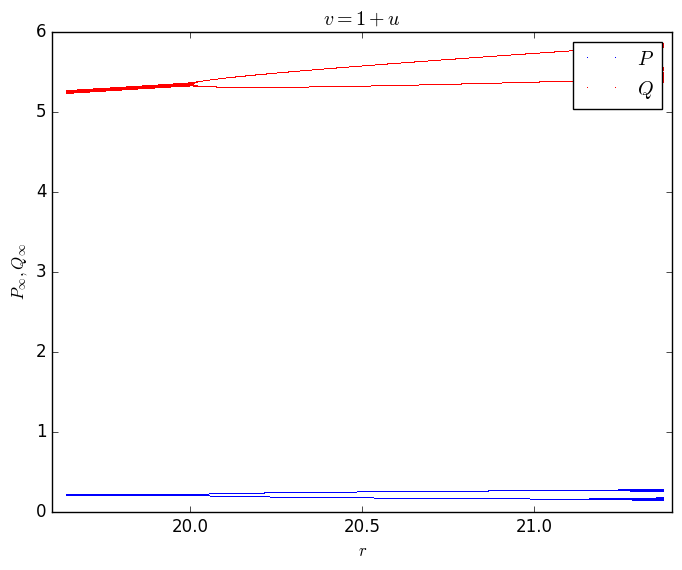

In [18]:
u=0.25
v=1+u
rrange2 = 19.6416:2.0^-9:25.0
pE2_2(r)=pE2([r,s,u,v])+[0.01,-0.061]
plot1(F2, pE2_2, rrange2, 1000,200,L"v=1+u");

En estos casos inciales observamos que los casos con bifurcaciones de doblamiento de periódo aparecen sólo con eigenvalores reales.

Justo en el valor donde se predice que el comportamiento ya no es estable, $r>\frac{4v}{u(2+u-v)}$, en este caso  `r=2.0905...` el valor de los depredadores cambia de comportamiento, cayendo y dando lugar a un diagrama de bifurcación sólo para las presas.

### Caso real, $\Delta \geq 0 \Leftrightarrow r\geq-\frac{4(uv-v^2)}{u}$ y $\lambda_{-}\geq-1$

4. $v=u=1$ y $r\leq2$

In [19]:
u=0.25
v=u
4*v/(u*(2+u-v))

2.0

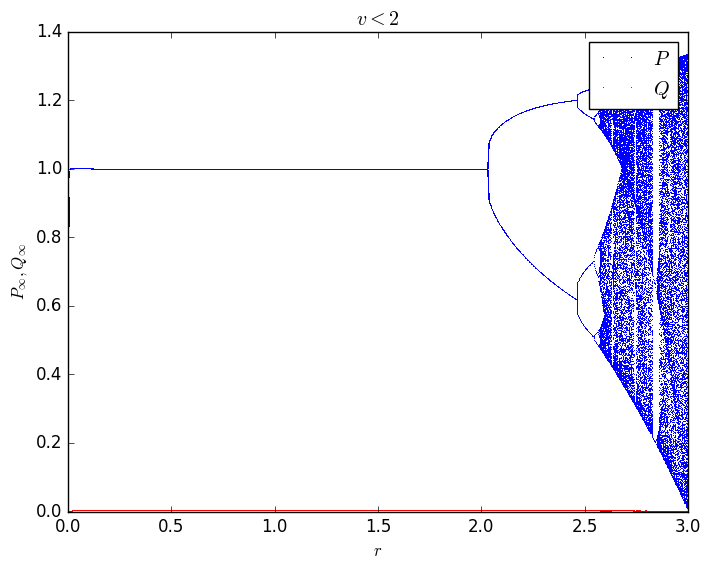

In [20]:
rrange3 = 0.0:2.0^-9:10.0
pE2_3(r)=pE2([r,s,u,v])+[0.1,0.1]
F3(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);
plot1(F3, pE2_3, rrange3, 1000,200,L"v<2");

En este caso observamos un gráfico en que los depredadores se mantienen en un valor muy cercano a 0.0, y al entrar en la zona sin estabilidad, comienza el diagrama de bifurcaciones después del punto donde se predice que $r$ será estable.

$r\leq\frac{4v}{u(2+u-v)}$ con $v<u+1$.

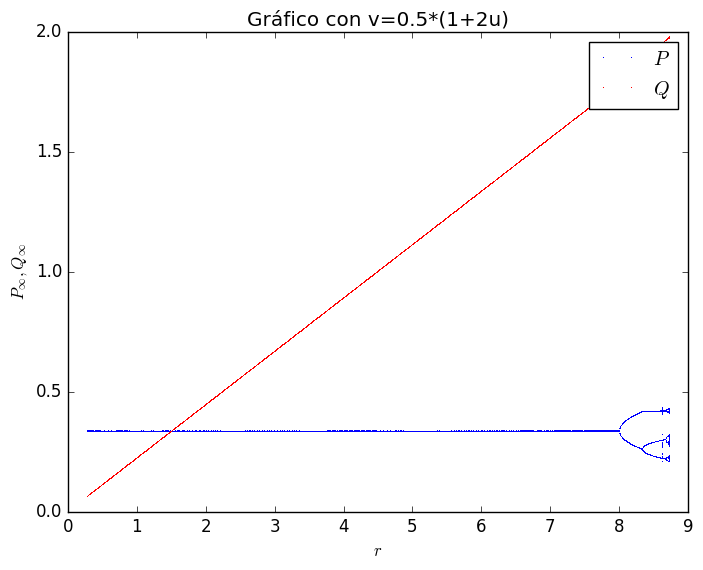

In [21]:
s,u,K = 3.0,0.25,1.0
v=0.5(1+2u)
p3(r)=pE2([r,s,u,v])-[0.0,0.06]
F3(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);
rrange3 = 0.0:2.0^-8:10.0
plot1(F3, p3, rrange3, 20000,500, "Gráfico con v=0.5*(1+2u)");

In [22]:
4*v/(u*(2+u-v))

8.0

In [23]:
es_estable([8.1,s,u,v])

-1

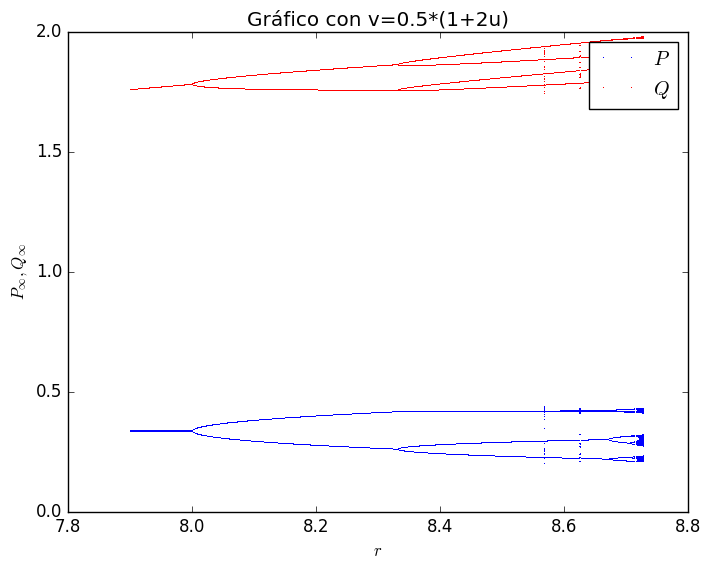

In [24]:
rrange3 = 7.9:2.0^-10:9.0
R3,P3,Q3=plot1(F3, p3, rrange3, 20000,500, "Gráfico con v=0.5*(1+2u)");

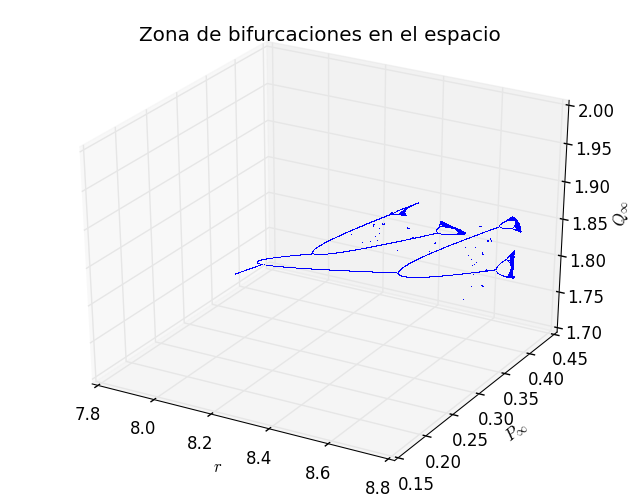

PyObject <matplotlib.text.Text object at 0x00000000264AE4A8>

  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
in show at C:\Users\Rodolfo\.julia\v0.5\PyCall\src\PyCall.jl
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
i

In [25]:
PyPlot.plot3D(R3,P3,Q3,"b,")
xlabel(L"r")
ylabel(L"P_\infty")
zlabel(L"Q_\infty")
title("Zona de bifurcaciones en el espacio")

Los gráficos muestran diagramas de bifurcación pero ahora en una ubicación espacial. Nuevamente aparecen las bifurcaciones justo en el punto donde la prueba del Lagrangeano dice que serán inestables.